In [1]:
import pandas as pd
import numpy as np 
import ROOT
import root_numpy
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

# from sklearn.preprocessing import StandardScaler
# ss=StandardScaler()

from sklearn.preprocessing import MinMaxScaler
minmax=MinMaxScaler()

from sklearn.metrics import roc_auc_score

from sklearn.metrics import confusion_matrix

sns.set_style('darkgrid')

from sklearn.model_selection import GridSearchCV,RandomizedSearchCV



import warnings
warnings.filterwarnings('ignore')

Welcome to JupyROOT 6.22/08


In [2]:
def quantile_fun(col):

    q1=col.quantile(0.25)
    q3=col.quantile(0.75)
    iqr=q3-q1
    lw=q1-(1.5*iqr) #LowerWhisker
    uw=q3+(1.5*iqr) #UpperWhisker
    new_col=[]
    for i in col:
        if i<lw:
            i=lw
            new_col.append(i)
        elif i>uw:
            i=uw
            new_col.append(i)
        else:
            i=i
            new_col.append(i)
    return np.array(new_col)

In [3]:
data_path='datasets/Brunel_BdJPsiKs_MagU_30k.root'
root_file=ROOT.TFile(data_path)
root_file.cd("ToolSvc.PatDebugTTTruthTool")
tree = ROOT.gDirectory.Get("DownstreamSeedDebugTuple")
original_data=pd.DataFrame(root_numpy.tree2array(tree))
data=original_data.head(10000)
#data=original_data

In [4]:
data['seed_r'] = np.sqrt(np.square(data.seed_x) +np.square(data.seed_y))    
data['pseudo_rapidity'] = np.arctanh(data.seed_pt/data.seed_p)

In [5]:
data.columns

Index(['has_MCParticle', 'is_downstream_reconstructible',
       'has_MCParticle_not_electron',
       'is_downstream_reconstructible_not_electron', 'is_true_seed',
       'seed_chi2PerDoF', 'seed_p', 'seed_pt', 'seed_nLHCbIDs', 'seed_nbIT',
       'seed_nLayers', 'seed_x', 'seed_y', 'seed_tx', 'seed_ty',
       'seed_mva_value', 'seed_r', 'pseudo_rapidity'],
      dtype='object')

In [6]:
data=data.drop(['has_MCParticle','has_MCParticle_not_electron',
       'is_downstream_reconstructible_not_electron', 'is_true_seed','seed_mva_value'],axis=1)

In [7]:
x=data.drop(['is_downstream_reconstructible'],axis=1)
y=data['is_downstream_reconstructible'].map({True:0,False:1})

In [8]:
x=x.apply(quantile_fun)
x=np.abs(x)
x=pd.DataFrame(minmax.fit_transform(x),columns=x.columns)

In [9]:
cat=CatBoostClassifier(iterations=100,verbose=10)

In [10]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42,shuffle=True)

In [11]:
cat.fit(x_train,y_train)

Learning rate set to 0.206801
0:	learn: 0.6346623	total: 63ms	remaining: 6.24s
10:	learn: 0.4662315	total: 102ms	remaining: 829ms
20:	learn: 0.4217989	total: 129ms	remaining: 485ms
30:	learn: 0.3971931	total: 156ms	remaining: 347ms
40:	learn: 0.3809588	total: 185ms	remaining: 267ms
50:	learn: 0.3649744	total: 219ms	remaining: 210ms
60:	learn: 0.3511141	total: 246ms	remaining: 157ms
70:	learn: 0.3394303	total: 276ms	remaining: 113ms
80:	learn: 0.3288826	total: 310ms	remaining: 72.8ms
90:	learn: 0.3200430	total: 337ms	remaining: 33.3ms
99:	learn: 0.3146309	total: 359ms	remaining: 0us


In [12]:
y_predict=cat.predict(x_test)
accuracy_score(y_test,y_predict)

0.844

In [13]:
score_list=[]
for i in cat.staged_predict_proba(x_test):
    predicted=i[:,1]
    score=roc_auc_score(y_test,predicted)
    score_list.append(score)

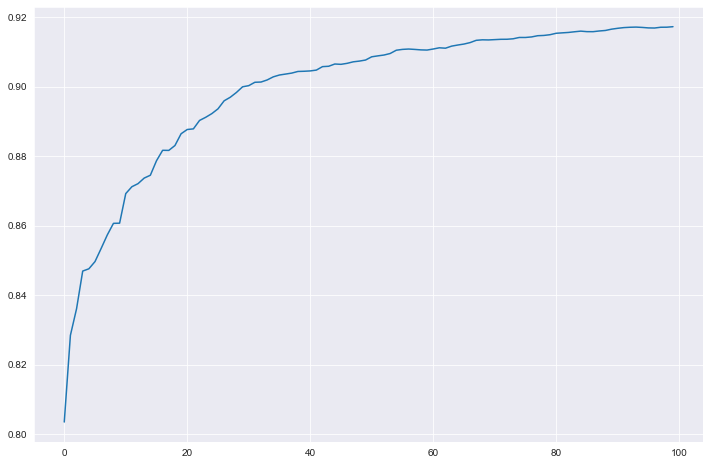

In [14]:
plt.figure(figsize=(12,8))
plt.plot(score_list)
plt.show()

In [15]:
print(roc_auc_score(y_test,y_predict))

0.8439115952043568


<AxesSubplot:>

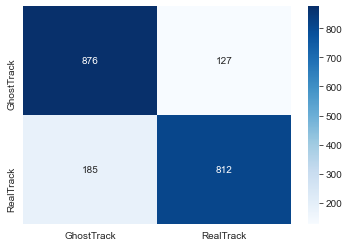

In [16]:
sns.heatmap(confusion_matrix(y_test,y_predict),fmt='d',annot=True,cmap='Blues',xticklabels=['GhostTrack','RealTrack'],yticklabels=['GhostTrack','RealTrack'])

## HyperParametric Tuning

In [17]:
params={'learning_rate':[0.001,0.01,0.1]}
rand=RandomizedSearchCV(estimator=cat,param_distributions=params,return_train_score=True)

In [18]:
rand.fit(x_train,y_train)

0:	learn: 0.6928410	total: 5.89ms	remaining: 584ms
10:	learn: 0.6897868	total: 40.9ms	remaining: 331ms
20:	learn: 0.6868044	total: 65.6ms	remaining: 247ms
30:	learn: 0.6838942	total: 90.9ms	remaining: 202ms
40:	learn: 0.6810024	total: 113ms	remaining: 163ms
50:	learn: 0.6782147	total: 137ms	remaining: 131ms
60:	learn: 0.6754083	total: 162ms	remaining: 103ms
70:	learn: 0.6726593	total: 192ms	remaining: 78.3ms
80:	learn: 0.6699467	total: 216ms	remaining: 50.7ms
90:	learn: 0.6673273	total: 244ms	remaining: 24.1ms
99:	learn: 0.6649457	total: 266ms	remaining: 0us
0:	learn: 0.6928369	total: 3.04ms	remaining: 301ms
10:	learn: 0.6897367	total: 29.6ms	remaining: 239ms
20:	learn: 0.6867173	total: 54.2ms	remaining: 204ms
30:	learn: 0.6837827	total: 79.4ms	remaining: 177ms
40:	learn: 0.6808669	total: 104ms	remaining: 150ms
50:	learn: 0.6781130	total: 130ms	remaining: 125ms
60:	learn: 0.6752924	total: 157ms	remaining: 100ms
70:	learn: 0.6724957	total: 179ms	remaining: 73.1ms
80:	learn: 0.6697850	to

RandomizedSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x7fec9183c400>,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.1]},
                   return_train_score=True)

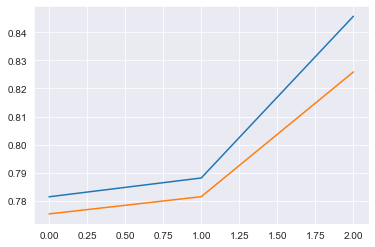

In [19]:
plt.plot(rand.cv_results_['mean_train_score'])
plt.plot(rand.cv_results_['mean_test_score'])

In [20]:
rand.best_score_

0.8258749999999999

In [33]:
params={'learning_rate':np.arange(0,1,0.001)}
grid=GridSearchCV(estimator=cat,param_grid=params,return_train_score=True)
grid.fit(x_train,y_train)

 175ms	remaining: 251ms
50:	learn: 0.2463456	total: 220ms	remaining: 212ms
60:	learn: 0.2334331	total: 259ms	remaining: 166ms
70:	learn: 0.2202311	total: 301ms	remaining: 123ms
80:	learn: 0.2069134	total: 340ms	remaining: 79.7ms
90:	learn: 0.1947684	total: 382ms	remaining: 37.8ms
99:	learn: 0.1825474	total: 429ms	remaining: 0us
0:	learn: 0.5207744	total: 4.21ms	remaining: 417ms
10:	learn: 0.3827548	total: 44.7ms	remaining: 362ms
20:	learn: 0.3238641	total: 81.3ms	remaining: 306ms
30:	learn: 0.2962219	total: 118ms	remaining: 263ms
40:	learn: 0.2703376	total: 177ms	remaining: 254ms
50:	learn: 0.2508508	total: 219ms	remaining: 211ms
60:	learn: 0.2336104	total: 257ms	remaining: 164ms
70:	learn: 0.2175863	total: 294ms	remaining: 120ms
80:	learn: 0.2035444	total: 337ms	remaining: 78.9ms
90:	learn: 0.1931392	total: 381ms	remaining: 37.7ms
99:	learn: 0.1831036	total: 423ms	remaining: 0us
0:	learn: 0.5212145	total: 5.36ms	remaining: 530ms
10:	learn: 0.3718031	total: 42.7ms	remaining: 345ms
20:	

GridSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x7fec9183c400>,
             param_grid={'learning_rate': array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
       0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
       0.018, 0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026,
       0.027, 0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035,
       0.036, 0.037, 0.038, 0.039, 0...
       0.945, 0.946, 0.947, 0.948, 0.949, 0.95 , 0.951, 0.952, 0.953,
       0.954, 0.955, 0.956, 0.957, 0.958, 0.959, 0.96 , 0.961, 0.962,
       0.963, 0.964, 0.965, 0.966, 0.967, 0.968, 0.969, 0.97 , 0.971,
       0.972, 0.973, 0.974, 0.975, 0.976, 0.977, 0.978, 0.979, 0.98 ,
       0.981, 0.982, 0.983, 0.984, 0.985, 0.986, 0.987, 0.988, 0.989,
       0.99 , 0.991, 0.992, 0.993, 0.994, 0.995, 0.996, 0.997, 0.998,
       0.999])},
             return_train_score=True)

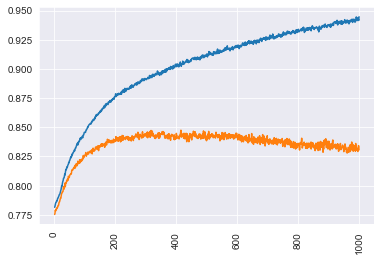

In [34]:
plt.plot(grid.cv_results_['mean_train_score'])
plt.plot(grid.cv_results_['mean_test_score'])
plt.xticks(rotation=90)
plt.show()

In [35]:
grid.best_params_

{'learning_rate': 0.41500000000000004}

In [36]:
grid.best_score_

0.8474999999999999

In [40]:
np.save('grid.npy',grid.cv_results_['mean_train_score'])